In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

In [0]:
LR = 0.035
EPOCHS = 7
BATCHSIZE = 16
CHANNELS = 32 #or 16
IMAGE_SIZE = 256
NBLOCK = 2 
DEPTH = 4
MOMENTUM = 0.9
METRIC_THRESH = 0.3  # Probability threshold to use for epoch-by-epoch IoU metric

DEBUG = False
DEBUG_SAMPLES = 2048

import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [0]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [0]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']=""
os.environ['KAGGLE_KEY']=""

In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [0]:
# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle competitions download -c rsna-pneumonia-detection-challenge

  0% 0.00/55.0 [00:00<?, ?B/s]
100% 55.0/55.0 [00:00<00:00, 37.8kB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 88.3MB/s]
  0% 0.00/51.8k [00:00<?, ?B/s]
100% 51.8k/51.8k [00:00<00:00, 40.3MB/s]
  0% 0.00/634k [00:00<?, ?B/s]
100% 634k/634k [00:00<00:00, 115MB/s]
 97% 122M/126M [00:00<00:00, 173MB/s]
100% 126M/126M [00:00<00:00, 191MB/s]
100% 3.16G/3.17G [01:29<00:00, 35.4MB/s]
100% 3.17G/3.17G [01:30<00:00, 37.8MB/s]


In [0]:
# unzipping takes a few minutes
!unzip -q -o stage_1_test_images.zip -d stage_1_test_images
!unzip -q -o stage_1_train_images.zip -d stage_1_train_images
!unzip -q -o stage_1_train_labels.csv.zip

# Approach

* Firstly a convolutional neural network is used to segment the image, using the bounding boxes directly as a mask. 
* Secondly connected components is used to separate multiple areas of predicted pneumonia.
* Finally a bounding box is simply drawn around every connected component.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* At the end of the network a single upsampling layer converts the output to the same shape as the input.

As the input to the network is 256 by 256 (instead of the original 1024 by 1024) and the network downsamples a number of times without any meaningful upsampling (the final upsampling is just to match in 256 by 256 mask) the final prediction is very crude. If the network downsamples 4 times the final bounding boxes can only change with at least 16 pixels.

In [0]:
import csv
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import KFold

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
#with open(os.path.join('../input/stage_1_train_labels.csv'), mode='r') as infile:
with open(os.path.join('stage_1_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
pneumonia_locations['00aecb01-a116-45a2-956c-08d2fa55433f']

[[288, 322, 94, 135], [547, 299, 119, 165]]

In [2]:
!ls

sample_data


# Load filenames

In [0]:
'''
# load and shuffle filenames
#folder = '../input/stage_1_train_images'
folder = 'stage_1_train_images'
filenames = os.listdir(folder)
random.seed(42)#to make better comparisons between runs
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
'''

"\n# load and shuffle filenames\n#folder = '../input/stage_1_train_images'\nfolder = 'stage_1_train_images'\nfilenames = os.listdir(folder)\nrandom.seed(42)#to make better comparisons between runs\nrandom.shuffle(filenames)\n# split into train and validation filenames\nn_valid_samples = 2560\ntrain_filenames = filenames[n_valid_samples:]\nvalid_filenames = filenames[:n_valid_samples]\nprint('n train samples', len(train_filenames))\nprint('n valid samples', len(valid_filenames))\nn_train_samples = len(filenames) - n_valid_samples\n"

In [0]:
'''
#Use cross-validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
folder = 'stage_1_train_images'
filenames = os.listdir(folder)
# split into train and validation filenames
train_filenames, valid_filenames = train_test_split(filenames, test_size=0.1, random_state=42)
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - len(valid_filenames)
n_valid_samples = len(filenames) - len(train_filenames)
'''

"\n#Use cross-validation\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.model_selection import cross_val_score\nfolder = 'stage_1_train_images'\nfilenames = os.listdir(folder)\n# split into train and validation filenames\ntrain_filenames, valid_filenames = train_test_split(filenames, test_size=0.1, random_state=42)\nprint('n train samples', len(train_filenames))\nprint('n valid samples', len(valid_filenames))\nn_train_samples = len(filenames) - len(valid_filenames)\nn_valid_samples = len(filenames) - len(train_filenames)\n"

In [0]:
#load file names
#folder = '../input/stage_1_train_images'
folder = 'stage_1_train_images'
filenames = os.listdir(folder)

# Exploration

Total train images: 25684
Images with pneumonia: 5659


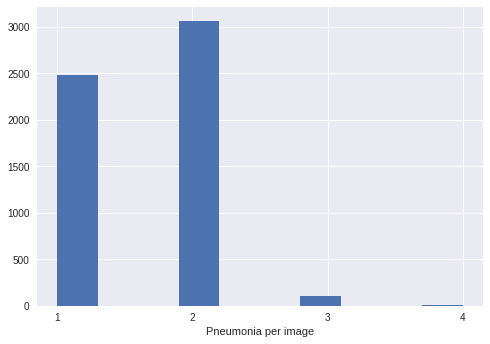

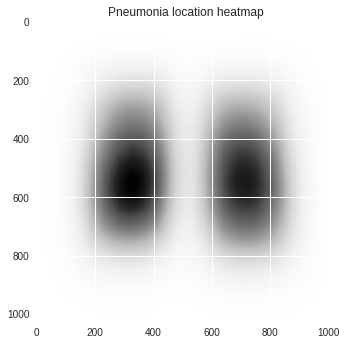

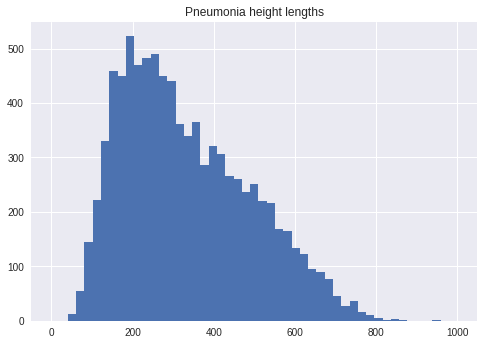

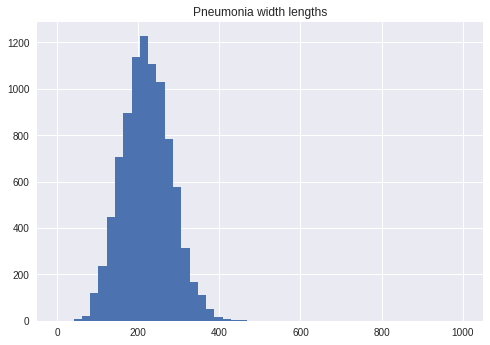

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns)
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap)
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50))
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50))
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.seed(42)#to make better comparisons between runs
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    x = keras.layers.Dropout(0.2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=NBLOCK, depth=DEPTH):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(256, 1, activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2DTranspose(128, (4,4), (2,2), padding="same", activation=None)(x)
    x = keras.layers.BatchNormalization(momentum=MOMENTUM)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.UpSampling2D(2**(depth-1))(x)
    outputs = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Train network


In [0]:
# IoU metric functions using tf.py_func, as suggested in  Marsh's (@vbookshelf) kernel:
#   https://www.kaggle.com/vbookshelf/keras-iou-metric-implemented-without-tensor-drama

def raw_iou(y_true, y_pred):
    results = []
    y_pred = y_pred > METRIC_THRESH
    for i in range(0,y_true.shape[0]):
        intersect = np.sum( y_true[i,:,:] * y_pred[i,:,:] )
        union = np.sum( y_true[i,:,:] ) + np.sum( y_pred[i,:,:] ) - intersect + 1e-7
        iou = np.mean((intersect/union)).astype(np.float32)
        results.append( iou )
    return np.mean( results )

def IoU(y_true, y_pred):
    iou = tf.py_func(raw_iou, [y_true, y_pred], tf.float32)
    return iou

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=CHANNELS, n_blocks=NBLOCK, depth=DEPTH)
model.compile(optimizer=keras.optimizers.Adam(lr=LR),
              loss=keras.losses.binary_crossentropy,
              metrics=['accuracy', IoU])

# create train and validation generators
kf = KFold(n_splits=3) 
# split into train and validation filenames
for train_fold, valid_fold in kf.split(filenames):
  train_filenames=[]
  valid_filenames=[]
  #put the names selected by kfold into train_filenames
  for i in range(len(train_fold)):
    name_position=train_fold[i]
    train_filenames.append(filenames[name_position])
  #put the names selected by kfold into valid_filenames
  for i in range(len(valid_fold)):
    name_position=valid_fold[i]
    valid_filenames.append(filenames[name_position])
  #print('valid_filenames:\n',valid_filenames[0:10])
  #print('train_filenames:\n',train_filenames[0:10])
  train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCHSIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
  valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCHSIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)
  history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=EPOCHS, shuffle=True, verbose=2)
  
  # Evaluation metric functions, from Yicheng Chen's kernel

# helper function to calculate IoU
def iou(box1, box2):
    x11, y11, w1, h1 = box1
    x21, y21, w2, h2 = box2
    assert w1 * h1 > 0
    assert w2 * h2 > 0
    x12, y12 = x11 + w1, y11 + h1
    x22, y22 = x21 + w2, y21 + h2

    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2-xi1) * (yi2-yi1)
        union = area1 + area2 - intersect
        return intersect / union
    
def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, w, h)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)
    

Epoch 1/7


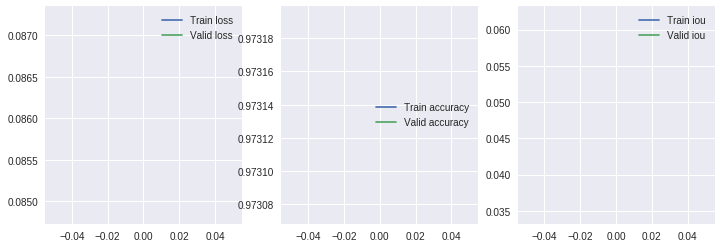

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["IoU"], label="Train iou")
plt.plot(history.epoch, history.history["val_IoU"], label="Valid iou")
plt.legend()
plt.show()

# Predict test images

In [0]:
# load and shuffle filenames
folder = 'stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=20, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 1000


## Run once

In [0]:
!pip install -U -q PyDrive

## Use if you want to upload a file

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# file: string (name of existing file)
# title: string (name which you want to give to the file being uploaded to Drive)
# returns the file_id of the uploaded file on Drive
def upload_file_to_drive(file, title):
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  export = drive.CreateFile({'title':title})  
  export.SetContentFile(file)
  export.Upload()

  return export['id']  

In [0]:
!ls

sample_data


### upload a file on your Colab VM to your GDrive

In [0]:
file_id = upload_file_to_drive('submission.csv', 'submission.csv')
file_id

FileNotFoundError: ignored